# Build Micrograd (Part 2)

Now in the first half of the video we built the basic structure of Micrograd and also understood the backpropagation process manually and with topological sorting.

In this second part, we will start with a clean slate so the code is not all messy and we just have the important parts for automatic differentiation.


In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label = ''):
    """
    Creating Initial Value
    Args:
      data: some numerical value
      grad: gradient of the value (derivative)
      _backward: function to propagate the gradient backward
      _children: a tuple of previous operations
      _op: symbol representing the operation (+, *, etc.)
      label: a string label for the value (name of the variable for visualization)
    """
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other): # self ** other
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self): # -self
    return self * -1
  
  def __sub__(self, other): # self - other
    return self + (-other)

  # This is a fallback for __mul__, so if self * other fails we do other * self
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Build the topological order
    topo = []
    visited = set()

    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)

    build_topo(self)

    # Reverse the topological order
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [4]:
# This is some copy pasted code that will help visualize the operation chain and it will make sense why are we storing the previous values and operations.

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# HOW TO USE
# You can use the draw_dot function to visualize the computation graph of a Value object.
# Simply call draw_dot(d) where d is the Value object you want to visualize.


In [7]:
# Following is an equation for a simple neuron with two inputs
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# apply the tanh activation function
o = n.tanh(); o.label = 'o'

o.backward()

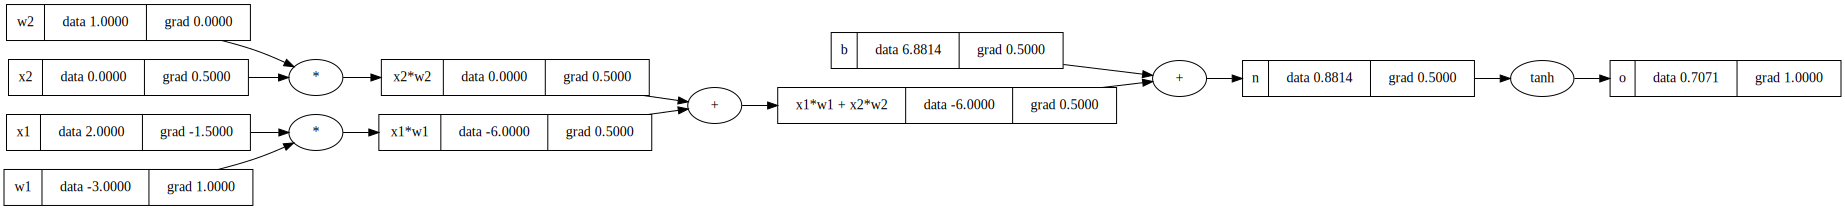

In [8]:
draw_dot(o)

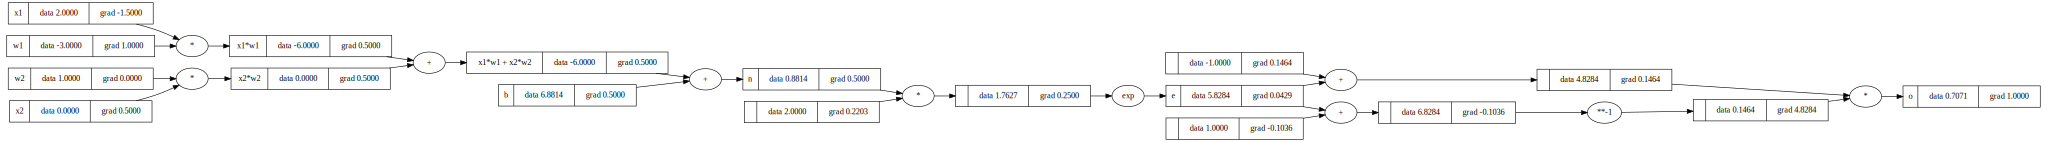

In [17]:
# Lets edit the old equation so we use different way to do tanh
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------------
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# ------------
o.label = 'o'

o.backward()

draw_dot(o)

---
## Using PyTorch

Now we will do that same thing we did but a proper library (pytorch). This was some small learning that was based on PyTorch. PyTorch is a powerful library for building and training neural networks, it is used in production by many companies and researchers.


In [2]:
# in PyTorch we have torch.Tensor instead of Value which we used.
import torch

In [3]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
